<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Columns" data-toc-modified-id="Columns-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Columns</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Outliers</a></span></li></ul></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train-Test Split</a></span></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Selection</a></span><ul class="toc-item"><li><span><a href="#Autocorrelation-Analysis" data-toc-modified-id="Autocorrelation-Analysis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Autocorrelation Analysis</a></span></li><li><span><a href="#Penalized-Liklihood-Criteria" data-toc-modified-id="Penalized-Liklihood-Criteria-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Penalized Liklihood Criteria</a></span></li></ul></li><li><span><a href="#Naive-Model" data-toc-modified-id="Naive-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Naive Model</a></span></li><li><span><a href="#AR-Model" data-toc-modified-id="AR-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>AR Model</a></span></li><li><span><a href="#ARIMA-Model" data-toc-modified-id="ARIMA-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ARIMA Model</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Facebook Prophet</a></span></li></ul></div>

# Data Cleaning

In [201]:
# frequently used libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# statistical analysis libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series analysis libraries
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet 

# root mean square error libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

In [202]:
orders_df = pd.read_csv('olist_orders_dataset.csv')
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


## Columns

In [203]:
orders_df.drop(['order_status',
                'customer_id',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date'], axis='columns', inplace=True)
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  99441 non-null  object
 1   order_purchase_timestamp  99441 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [204]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df.dtypes

order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [205]:
orders_df[orders_df.duplicated()]

,order_id,order_purchase_timestamp


In [206]:
orders_df.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [207]:
orders_df['purchase_date'] = orders_df['order_purchase_timestamp'].dt.date
raw_daily_sales_df = pd.DataFrame(orders_df.groupby('purchase_date')['order_id'].count())
raw_daily_sales_df.columns = ['sales']
raw_daily_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 2016-09-04 to 2018-10-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   634 non-null    int64
dtypes: int64(1)
memory usage: 9.9+ KB


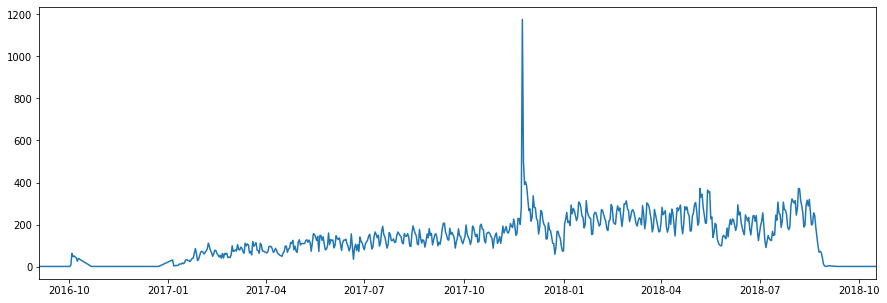

In [208]:
plt.figure(figsize=(15,5))
plt.plot(raw_daily_sales_df)
plt.autoscale(enable=True, axis='x', tight=True)

## Outliers

It is observed that there are three regions of irregularities in the the beginning, middle, and end of the time series. In the begining there are almost no sales until around January of 2017 and even then the sales starts gradualling increasing until it reachs regular sales trends at around April of 2017. This can be associated with the store just starting or switching business. In the middle, there is a significant peak at around new year which represents a lot of people buying new items for themselvs or gifts for others. Finally at the end the sales suddenly decreases from around September 2018 till end where there is no sales what so ever. This can be associated with the store shutting down, switching business, or an unexpected crisis. 

The irregularities in the begining and the end are clearly irrelevant for the purpose of steady-state forcasting. Even though the middle peak can be considered in the forcasting problem, there are no information available about previous cycles, so it was decided to remove all three outliers as follows:

In [209]:
daily_sales_df = raw_daily_sales_df[(raw_daily_sales_df.index > dt.date(2017, 4, 1)) & # remove before April of 2017
                                    (raw_daily_sales_df.index < dt.date(2018, 9, 1)) & # remove after September of 2018
                                    (raw_daily_sales_df.sales < 400)] # remove excessively high peaks

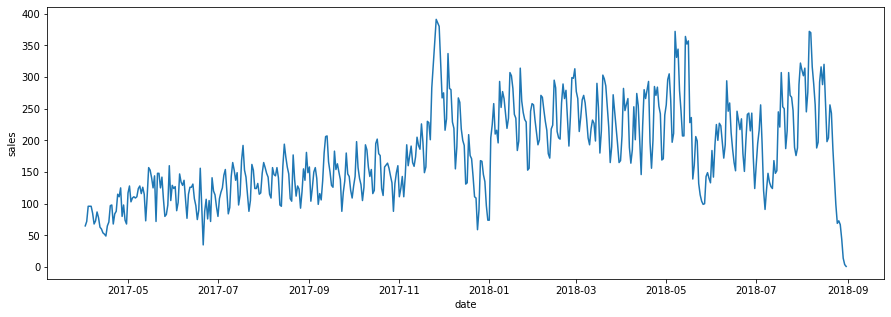

In [210]:
plt.figure(figsize=(15,5))
plt.plot(daily_sales_df)
plt.xlabel('date')
plt.ylabel('sales');

# Train-Test Split

The cleaned data has consistent trend without any irregularities, so this time series is used for further analytics. Test size is selected as a quarter of the data points based on which the time series is split into train and test series as follows:

In [211]:
test_size = int(daily_sales_df.shape[0] * 0.25)
train_df = daily_sales_df.iloc[:-test_size]
test_df = daily_sales_df.iloc[-test_size:]

The train test split is visualized in the time series as follows:

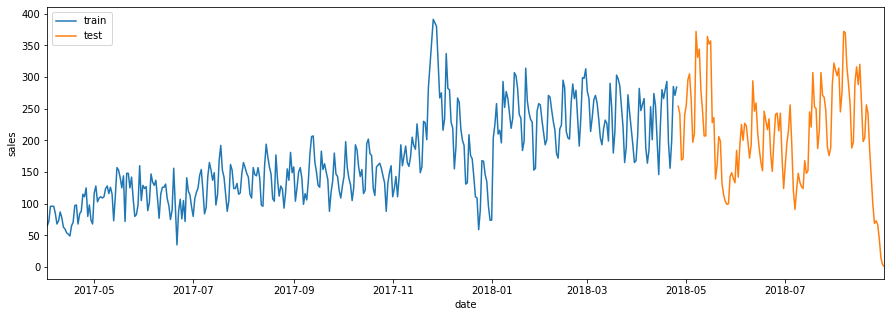

In [212]:
plt.figure(figsize=(15,5))
plt.plot(train_df, label='train')
plt.plot(test_df, label='test')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

# Model Selection

## Autocorrelation Analysis

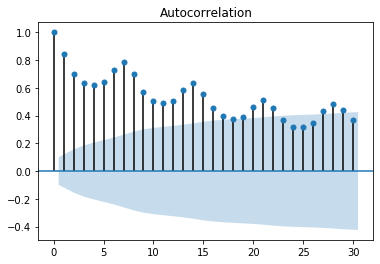

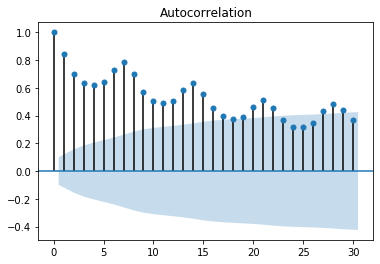

In [213]:
plot_acf(train_df, lags=30)  

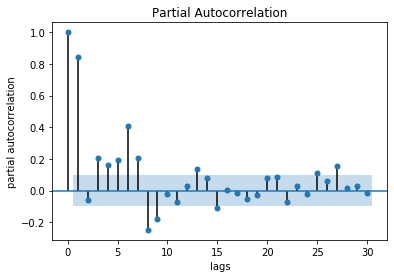

In [214]:
plot_pacf(train_df, lags=30)  
plt.xlabel('lags')
plt.ylabel('partial autocorrelation');

## Penalized Liklihood Criteria

In [215]:
orders = [1, 6, 8, 15, 21]

for order in orders:
    
    ar = AR(train_df).fit(maxlag=order)
    print('AIC for AR(%s): %s'%(order, ar.aic))

AIC for AR(1): 7.11480399621503
AIC for AR(6): 6.8385944866413
AIC for AR(8): 6.731199905386898
AIC for AR(15): 6.696815956311631
AIC for AR(21): 6.722988808410057


In [216]:
orders = [1, 6, 8, 15, 21]

for order in orders:
    
    ar = AR(train_df).fit(maxlag=order)
    print('BIC for AR(%s): %s'%(order, ar.bic))

BIC for AR(1): 7.145608489728961
BIC for AR(6): 6.921545460382783
BIC for AR(8): 6.835297635429744
BIC for AR(15): 6.8762645683448556
BIC for AR(21): 6.968735764937173


# Naive Model

In [217]:
test_df

,sales
purchase_date,
2018-04-26,254
2018-04-27,242
2018-04-28,169
2018-04-29,171
2018-04-30,240
...,...
2018-08-27,67
2018-08-28,44
2018-08-29,14


The naive method simply substitutes the last value in the train set as forcast for all test points as follows:

In [218]:
naive_predictions = test_df.copy()
naive_predictions.iloc[:, 0] = train_df.iloc[-1, 0]
naive_predictions

,sales
purchase_date,
2018-04-26,284
2018-04-27,284
2018-04-28,284
2018-04-29,284
2018-04-30,284
...,...
2018-08-27,284
2018-08-28,284
2018-08-29,284


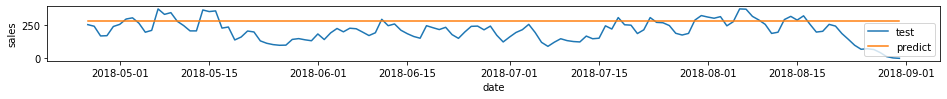

In [219]:
plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(naive_predictions, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

In [220]:
naive_rmse = sqrt(mean_squared_error(test_df, naive_predictions))/np.mean(test_df.values)
print('RMSE Score:', naive_rmse)

RMSE Score: 0.5104113756712922


# AR Model

Lag: 2
Coefficients: const       26.961898
L1.sales     0.898431
L2.sales    -0.056049
dtype: float64


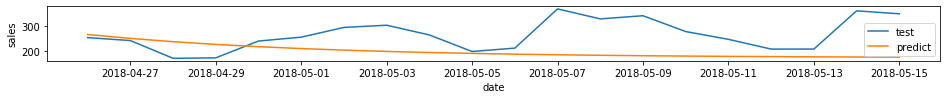

In [221]:
ar = AR(train_df)
ar_fit = ar.fit(maxlag=2)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag2_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag2_20_df = pd.DataFrame({'predictions': predictions_lag2_20.values}, index=test_df[:20].index)

plt.figure(figsize=(16,1))
#plt.plot(train_df, label='train')
plt.plot(test_df[:20], label='test')
plt.plot(predictions_lag2_20_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

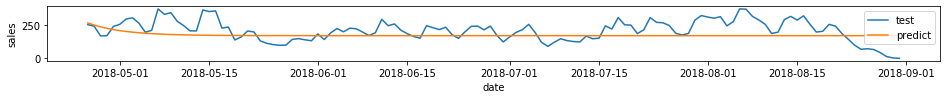

In [222]:
predictions_lag2 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag2_df = pd.DataFrame({'predictions': predictions_lag2.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(predictions_lag2_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

Lag: 8
Coefficients: const       9.354557
L1.sales    0.724596
L2.sales   -0.123384
L3.sales    0.022437
L4.sales    0.076676
L5.sales   -0.103787
L6.sales    0.205893
L7.sales    0.407326
L8.sales   -0.259008
dtype: float64


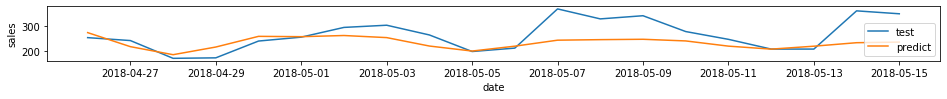

In [223]:
ar = AR(train_df)
ar_fit = ar.fit(maxlag=8)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag8_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag8_20_df = pd.DataFrame({'predictions': predictions_lag8_20.values}, index=test_df[:20].index)

plt.figure(figsize=(16,1))
plt.plot(test_df[:20], label='test')
plt.plot(predictions_lag8_20_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

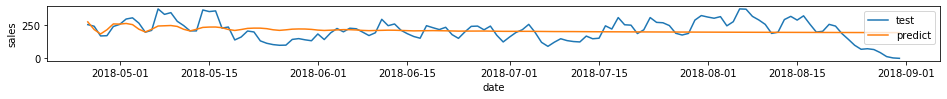

In [224]:
predictions_lag8 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag8_df = pd.DataFrame({'predictions': predictions_lag8.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(predictions_lag8_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

Increasing the lag improves the forcasting performance in the starting region of the test set; however, it gradually dies out as is the typical of the AR model.

In [225]:
lag8_rmse = sqrt(mean_squared_error(test_df, predictions_lag8_df))/np.mean(test_df.values)
print('RMSE Score:', lag8_rmse)

RMSE Score: 0.35837869467690453


# ARIMA Model

Through trials and errors, 6, 2, 5 have been identified as the optimal coefficients for the AR, I, and MA components, respectively.

In [226]:
arima = SARIMAX(train_df, order=(6, 2, 5),
                enforce_stationarity=False, 
                enforce_invertibility=False)
arima_fit = arima.fit()

print('Coefficients: %s' % arima_fit.params)

Coefficients: ar.L1       0.334286
ar.L2      -1.220450
ar.L3       0.278701
ar.L4      -0.844533
ar.L5      -0.312765
ar.L6      -0.163331
ma.L1      -1.637075
ma.L2       1.773002
ma.L3      -1.795965
ma.L4       1.350378
ma.L5      -0.688911
sigma2    822.450337
dtype: float64


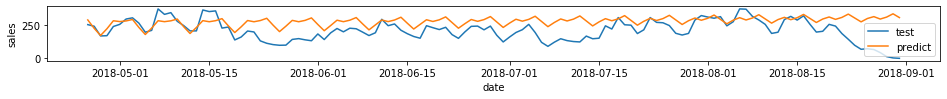

In [227]:
arima_predictions = arima_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
arima_predictions_df = pd.DataFrame({'predictions': arima_predictions.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(arima_predictions_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

Addition of integration and moving average components helps to sustain the forcast.

In [228]:
print('RMSE Score:', sqrt(mean_squared_error(test_df, arima_predictions_df))/np.mean(test_df.values))

RMSE Score: 0.4930426145980988


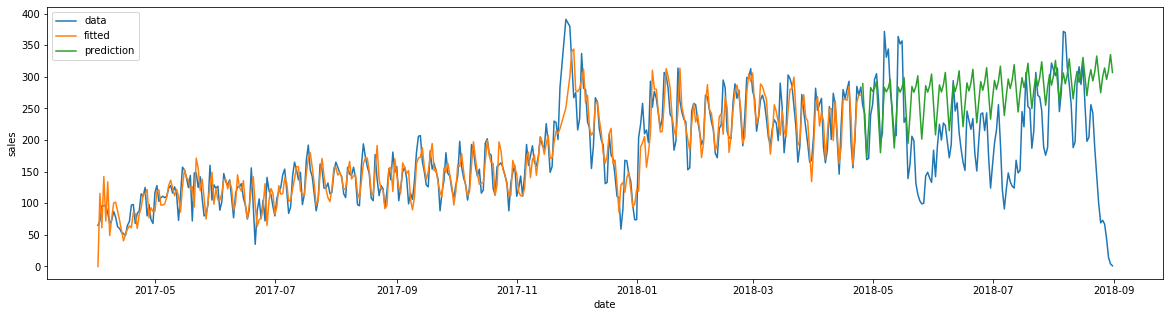

In [229]:
plt.figure(figsize=(20,5))
plt.plot(daily_sales_df, label='data')
plt.plot(arima_fit.fittedvalues, label='fitted')
plt.plot(arima_predictions_df, label='prediction')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

# Facebook Prophet

In [230]:
daily_sales_df

,sales
purchase_date,
2017-04-02,65
2017-04-03,72
2017-04-04,96
2017-04-05,96
2017-04-06,96
...,...
2018-08-27,67
2018-08-28,44
2018-08-29,14


In [231]:
sales_df = pd.DataFrame(orders_df.groupby('purchase_date')['order_id'].count())
daily_sales_prohpet_df = daily_sales_df.reset_index()
daily_sales_prohpet_df.columns = ['ds', 'y']
daily_sales_prohpet_df.head()

,ds,y
0,2017-04-02,65
1,2017-04-03,72
2,2017-04-04,96
3,2017-04-05,96
4,2017-04-06,96


In [232]:
train_prophet_df = daily_sales_prohpet_df.iloc[:-test_size]
test_prophet_df = daily_sales_prohpet_df.iloc[-test_size:]

In [233]:
holidays = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2018-12-01', '2018-12-02', '2018-12-08',
                        '2018-12-09', '2018-12-13', '2018-12-15',
                        '2018-12-16', '2018-12-22', '2018-12-23',
                        '2018-12-24', '2018-12-25', '2018-12-26',
                        '2018-12-27', '2018-12-28']),
 
})

In [234]:
prophet = Prophet(interval_width=0.95, holidays=holidays)
prophet.fit(train_prophet_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [235]:
prophet = Prophet(n_changepoints=20, 
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            changepoint_prior_scale=0.5)
prophet.add_country_holidays(country_name='US')

In [236]:
prophet.fit(train_prophet_df)
future = prophet.make_future_dataframe(periods=test_size, freq='D', include_history=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [237]:
forecast = prophet.predict(future)

In [238]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-04-26,252.258929,230.850550,288.258587,252.258929,252.258929,0.0,0.0,0.0,0.0,...,8.153712,8.153712,8.153712,-1.296965,-1.296965,-1.296965,0.0,0.0,0.0,259.115676
1,2018-04-27,252.687877,214.467081,272.047687,252.687877,252.687877,0.0,0.0,0.0,0.0,...,-9.837032,-9.837032,-9.837032,0.619361,0.619361,0.619361,0.0,0.0,0.0,243.470207
2,2018-04-28,253.116824,184.429541,241.612053,253.116824,253.116824,0.0,0.0,0.0,0.0,...,-41.838706,-41.838706,-41.838706,2.430940,2.430940,2.430940,0.0,0.0,0.0,213.709059
3,2018-04-29,253.545772,204.939492,264.938542,253.545772,253.545772,0.0,0.0,0.0,0.0,...,-21.778329,-21.778329,-21.778329,4.116810,4.116810,4.116810,0.0,0.0,0.0,235.884252
4,2018-04-30,253.974720,254.580466,317.812325,253.974645,253.974827,0.0,0.0,0.0,0.0,...,26.274756,26.274756,26.274756,5.660168,5.660168,5.660168,0.0,0.0,0.0,285.909644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2018-08-27,305.019487,289.922585,346.034626,304.712180,305.322271,0.0,0.0,0.0,0.0,...,26.274756,26.274756,26.274756,-14.283194,-14.283194,-14.283194,0.0,0.0,0.0,317.011048
124,2018-08-28,305.448434,285.897333,342.598259,305.136523,305.754408,0.0,0.0,0.0,0.0,...,23.161950,23.161950,23.161950,-14.548704,-14.548704,-14.548704,0.0,0.0,0.0,314.061680
125,2018-08-29,305.877382,277.264784,335.352604,305.561187,306.188578,0.0,0.0,0.0,0.0,...,15.863649,15.863649,15.863649,-14.668600,-14.668600,-14.668600,0.0,0.0,0.0,307.072431
126,2018-08-30,306.306329,269.274125,328.774129,305.986362,306.620966,0.0,0.0,0.0,0.0,...,8.153712,8.153712,8.153712,-14.639602,-14.639602,-14.639602,0.0,0.0,0.0,299.820439


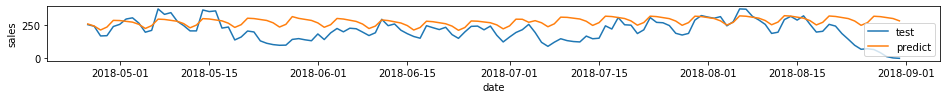

In [239]:
plt.figure(figsize=(16,1))
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], label='test')
plt.plot(test_prophet_df['ds'], forecast['yhat'], label='predict') 
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

In [242]:
print('RMSE Score:', sqrt(mean_squared_error(test_prophet_df['y'], forecast['yhat']))/np.mean(test_df.values))

RMSE Score: 0.4742873619820255


The results show that the test data is contained within the upper and lower bounds of the uncertainty intervals.